In [17]:
# %% 导入必要模块
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils.data import get_dataset



def simulate_occlusion(
    img, 
    occlusion_prob=1, 
    min_ratio=0.15, 
    max_ratio=0.25, 
    min_num=2, 
    max_num=3
):
    """
    在图像上随机添加多个较小的遮挡块（黑色矩形）。
    :param img: numpy.ndarray, (H, W) 或 (H, W, C)，灰度或彩色图像
    :param occlusion_prob: 添加遮挡的概率，如果没达到这个概率则不添加任何遮挡
    :param min_ratio: 单个遮挡块相对于图像宽/高的最小比例
    :param max_ratio: 单个遮挡块相对于图像宽/高的最大比例
    :param min_num: 最少添加多少个遮挡块
    :param max_num: 最多添加多少个遮挡块
    :return: 添加遮挡后的图像
    """
    if np.random.rand() < occlusion_prob:
        h, w = img.shape[:2]
        # 在 [min_num, max_num] 范围内随机选多少个遮挡块
        num_occ = np.random.randint(min_num, max_num + 1)

        for _ in range(num_occ):
            # 随机生成遮挡块的宽度和高度
            occ_w = np.random.randint(int(w * min_ratio), int(w * max_ratio) + 1)
            occ_h = np.random.randint(int(h * min_ratio), int(h * max_ratio) + 1)

            # 随机选择遮挡块在图像中的位置
            x1 = np.random.randint(0, w - occ_w + 1)
            y1 = np.random.randint(0, h - occ_h + 1)
            x2 = x1 + occ_w
            y2 = y1 + occ_h

            # 将区域置为 0（黑色），适用于灰度或彩色图像
            if len(img.shape) == 2:  # 灰度图
                img[y1:y2, x1:x2] = 0
            else:  # 彩色图
                img[y1:y2, x1:x2, :] = 0
    return img



In [18]:
# %% 加载数据集
Dataset = get_dataset("jacquard")
dataset_path = "/root/autodl-tmp/jacquard"
dataset = Dataset(dataset_path, start=0.0, end=1.0, ds_rotate=0, include_depth=1, include_rgb=0)




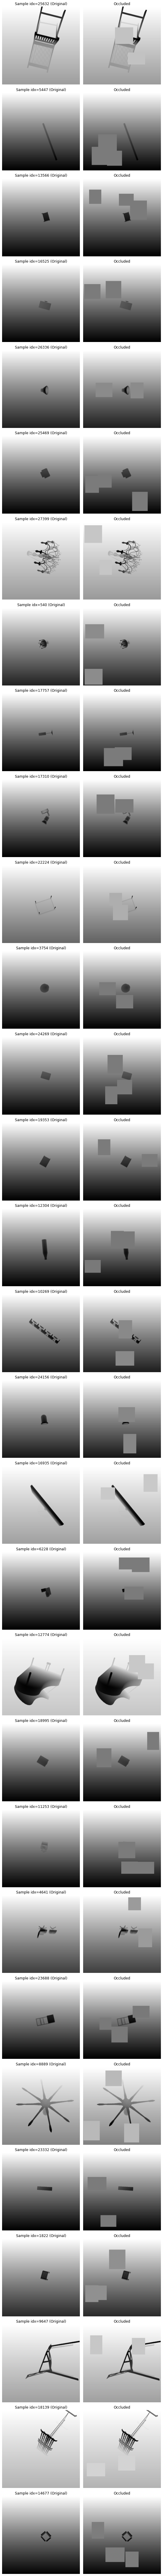

In [20]:
# %% 一次显示多行，每行包含两个子图：左边原图，右边遮挡图
num_samples_to_show = 30  # 想展示多少个样本
fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(8, 4 * num_samples_to_show))

for i in range(num_samples_to_show):
    # 1. 随机获取索引
    idx = np.random.randint(0, len(dataset))
    # 2. 获取样本
    sample, label, _, _, _ = dataset[idx]

    # 如果 sample 是 PyTorch Tensor，需要转换为 NumPy 数组
    if isinstance(sample, torch.Tensor):
        sample_np = sample.clone().detach().cpu().numpy()
    else:
        sample_np = sample

    # 如果图像形状是 (1, H, W)，则去掉通道维
    if sample_np.ndim == 3 and sample_np.shape[0] == 1:
        sample_np = sample_np.squeeze(0)

    # 3. 制作一份拷贝并进行遮挡
    sample_occluded = sample_np.copy()
    sample_occluded = simulate_occlusion(sample_occluded, occlusion_prob=1.0)  # 这里设为1.0方便对比

    # 4. 在子图中显示
    # 左边：原图
    axes[i, 0].imshow(sample_np, cmap='gray')
    axes[i, 0].set_title(f"Sample idx={idx} (Original)")
    axes[i, 0].axis('off')

    # 右边：遮挡图
    axes[i, 1].imshow(sample_occluded, cmap='gray')
    axes[i, 1].set_title("Occluded")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()